In [6]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime
# local imports
import sys

sys.path.insert(1, '../')
from utilities import utilities
#from ..utilities import utilities

In [7]:
# configure tqdm printing
#%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

/home/renato/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [8]:
path = '../physiobank_tool/challenge'
#ecg_filtered = butter_bandpass_filter(ecg_data, 1, sample_rate/5, sample_rate, 7)

number_of_segments = 120
low_cut = 1 # specific for this dataset

In [10]:
files = []

with open(path+'/header.txt') as f:
    reader = csv.reader(f)
    for row in reader:
        #print(row)
        files.append(row[0])
print("Read data for the following drivers:\n", files[:10])

FileNotFoundError: [Errno 2] No such file or directory: '../physiobank_tool/challenge/header.txt'

In [5]:
def read_file(file_name):
    ''' Read ecg information from a file and saves it to a dataframe  '''
    cols_of_interest = [0,1]
    ecg_data = pd.read_csv(f'{path}/{file_name}.csv', usecols=cols_of_interest)
    # drop useless header
    ecg_data = ecg_data.drop(ecg_data.index[0])
    # name columns
    ecg_data.columns = ['time', 'ECG']
    # cast some columns to float
    ecg_data['time'] = ecg_data['time'].astype(float)
    ecg_data['ECG'] = ecg_data['ECG'].astype(float)
    
    return ecg_data

In [2]:
def run(ecg_data, file_name, number_of_segments, low_cut):
    """Execute the pipeline that segmentate and extract the features of a ecg signal 
    inputted as a dataframe"""
    sample_rate = utilities.detect_sample_rate(ecg_data)
    high_cut = sample_rate/5.0
    order = 7
    data_preparation_pipeline = Pipeline([
        ('filtering', utilities.Filter(sample_rate, low_cut, high_cut, order=order)),
        ('feature_detection', utilities.FeatureExtractor(number_of_segments, sample_rate)),
        ])

    processed_df, raw_df  = data_preparation_pipeline.fit_transform(ecg_data['ECG'])
    processed_df.reset_index(drop=True, inplace=True)
    raw_df.reset_index(drop=True, inplace=True)
    
    return raw_df, processed_df 

In [7]:
def remove_outliers(original_dataset, lower_threshold, upper_threshold, column_names=[]):
    ''' Remove outliers from a dataframe
        Everything above or below these percentiles will be cut off
    '''
    # TODO: add treatment for not numerical columns
    dataset = original_dataset.copy()
    
    if column_names:
        for column in column_names:
            removed_outliers = remove(dataset[column], lower_threshold, upper_threshold)
            # save the indexes of rows that must be removed
            indexes_for_removal = dataset[column][~removed_outliers].index
            # in fact remove outliers from this column 
            #print(indexes_for_removal)
            dataset.drop(indexes_for_removal, inplace=True)
            #print(f'removed {len(indexes_for_removal)} outliers for column {column}')
            #print(f'remaining itens in dataset: {len(dataset)}')
        return dataset
            
    else:
        column_names = list(dataset.columns)
        for column in column_names:
            removed_outliers = remove(dataset[column], lower_threshold, upper_threshold)
            # save the indexes of rows that must be removed
            indexes_for_removal = dataset[column][~removed_outliers].index
            # in fact remove outliers from this column 
            dataset.drop(indexes_for_removal, inplace=True)
        return dataset
    
def remove(series, lower_threshold, upper_threshold):
    ''' Remove outliers from a single pandas Series '''
    # create a boolean mask where False values are the outliers
    removed_outliers = series.between(series.quantile(lower_threshold),
                                      series.quantile(upper_threshold))
    return removed_outliers

In [8]:
# A final dataframe to store all subjects (people) ecg information 
processed_everyone_df = pd.DataFrame()
raw_everyone_df = pd.DataFrame()
# read every file and return the dataframe of extracted features for ech file
for file in tqdm(files):
    ecg_data = read_file(file)
    #ecg_data = ecg_data.iloc[:10000]
    raw_df, processed_df  = run(ecg_data, file, number_of_segments, low_cut)
    processed_df['person'] = file
    raw_df['person'] = file
    
    raw_everyone_df = pd.concat([raw_df, raw_everyone_df], ignore_index=True)
    processed_everyone_df = pd.concat([processed_df, processed_everyone_df], ignore_index=True)

../utilities/utilities.py:361: RuntimeWarning: invalid value encountered in double_scalars
  value = abs(features['s_y'] - segment[x]) / abs(features['s_x'] - x)
../utilities/utilities.py:372: RuntimeWarning: invalid value encountered in double_scalars
  value = abs(features['q_y'] - segment[x]) / abs(features['q_x'] - x)
../utilities/utilities.py:443: RuntimeWarning: Mean of empty slice
  mean_qrs_interval = np.nanmean(np.array(final_features['qrs_interval']))#, np.nanstd(np.array(final_features['qrs_interval']))
/home/renato/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/renato/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


I generated 120 samples for training

I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training


I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I

I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I

I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I

I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I

I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I

I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I generated 120 samples for training
I

In [9]:
# Adquire os dados do passo 3: passo 2 + remoção de outliers
lower_threshold = 0.002 # 0,5%
upper_threshold = 0.998 # 0,5%

column_names = list(processed_everyone_df.columns)
person_index = column_names.index('person')
column_names.pop(person_index)
cleaned_everyone_df = remove_outliers(raw_everyone_df,lower_threshold, upper_threshold, column_names=column_names)

In [10]:
# Check an example
cleaned_everyone_df.head(5)

,mean_q,mean_r,mean_s,mean_p,mean_t,stdev_q,stdev_r,stdev_s,mean_rr_interval,mean_rq_amplitude,mean_qrs_interval,mean_qs_distance,mean_qt_distance,person


In [11]:
# check if we have equivalent number of examples per class   
#cleaned_everyone_df['person'].value_counts()

In [14]:
# Save the final extracted features
# step 1
raw_everyone_df.to_csv(f"../extracted_features_files/challenge_raw_everyone.csv", index=False)
# step 2
processed_everyone_df.to_csv(f"../extracted_features_files/challenge_processed_everyone.csv", index=False)
# step 3
cleaned_everyone_df.to_csv(f"../extracted_features_files/challenge_cleaned_everyone.csv", index=False)

In [ ]:
## Examples below

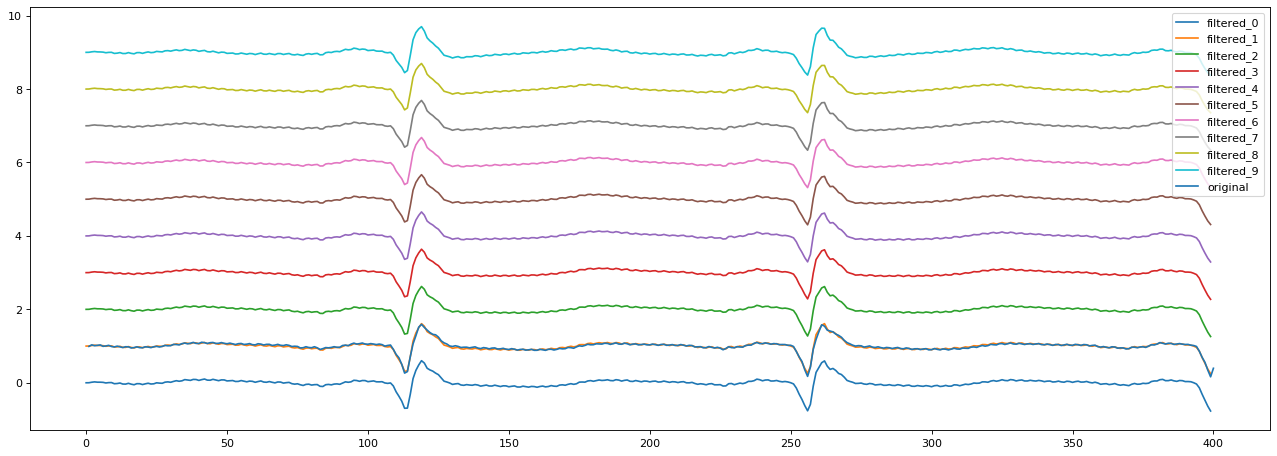

In [13]:
ecg_data = read_file(files[1])
sample_rate = utilities.detect_sample_rate(ecg_data)
two_seconds = ecg_data['ECG'][0:sample_rate*2]
plt.figure(figsize=(20, 7), dpi= 80, facecolor='w', edgecolor='k')

list_of_filters = [utilities.Filter(sample_rate, x, sample_rate/3.0) for x in np.linspace(0.1, 1, 10)]
list_of_filtered_signals = [x.fit_transform(two_seconds) + index for index, x in enumerate(list_of_filters)]

for index, signal in enumerate(list_of_filtered_signals):
    plt.plot(signal, label=f'filtered_{index}')
plt.plot(two_seconds+1.0, label='original')
plt.legend()